### Dependencies

In [0]:
# PyTorch
from os.path import exists

from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

cuda_output = !ldconfig -p | grep cudart.so | sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'

accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch

# # Pillow
!pip install Pillow==4.1.1

!pip install image

In [0]:
# !wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

# !wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

# !unzip -qq flower_data.zip

# !rm -f flower_data.zip || true

path_train = 'flower_data/train'

path_validation = 'flower_data/valid'

path_classes = 'cat_to_name.json'

### Imports

In [0]:
# Torch Vision
import torchvision

# Path
from pathlib import Path

# Matplot
import matplotlib.pyplot as pp

# Reduce
from functools import reduce

# Load
import json

# Numpy
import numpy as np

### GPU

In [4]:
# Check if CUDA is available
try:
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
       
    # Set default tensor
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
except:
    print('CPU')

Tesla K80


### Pre-processing <a name="pre-processing"></a>

The train dataset is loaded, resized, transformed to tensor and normalized; besides that, another transformations are applied to augment the dataset. The test dataset is a split of the validation dataset, 80% from the dataset is used to validation and 20% to test.

In [0]:
def load(path = None, transform = None):
    '''
        Load dataset
        
        Parameters
        ----------
        
        path: str
            Dataset path
        
        transform: torchvision.transforms
            Transform function
            
        Usage
        -----
        
        >>> load(path = '')
        
        Return
        ------
        
        Image Folder
        
        References
        ----------
        
        https://pytorch.org/docs/stable/torchvision/transforms.html
        
        https://pytorch.org/docs/stable/data.html
    '''
    
    pth = Path(path)
    
    if not pth.exists() or not pth.is_dir():
        raise Exception('Incompatible path')
    
    return torchvision.datasets.ImageFolder(root = path, transform = transform)

In [0]:
def plot(axe = None, images = None, cmap = 'gray', title = '', color = False):
    '''
        Plot images
        
        Parameters
        ----------
        
        axe: matplotlib.pyplot.subplots
            Matplot buffer
        
        images: torch.tensor
            Tensor matrix
            
        cmap: str
            Color map
        
        title: str
            Matrix title
        
        color: bool
            RGB images
            
        Usage
        -----
        
        Gray
        
        >>> figure, axe = pp.subplots(nrows=2, ncols=2, figsize=(2, 2))
        >>>
        >>> plot(axe, [torch.randn((4, 4)) for image in range(0, 4)])
        
        RGB
        
        >>> figure, axe = pp.subplots(nrows=2, ncols=2, figsize=(2, 2))
        >>>
        >>> plot(axe, [torch.randn((4, 4, 3)) for image in range(0, 4)], color = True)
        
        Return
        ------
        
        None
        
        References
        ----------
        
        https://matplotlib.org/examples/color/colormaps_reference.html
    '''
        
    if len(axe.shape) == 1:
        count = 0
        
        for col in range(axe.shape[0]):
            if color:
                axe[col].imshow(images[count].numpy().transpose((1, 2, 0)))
            else:
                axe[col].imshow(images[count].numpy().squeeze(), cmap=cmap)
            
            axe[col].axis('off')
            
            if title:
                axe[col].set_title(title)
            
            count += 1
    else:
        raise Exception('Invalid shape')

In [0]:
# Normalize
normalize = torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))

In [8]:
# Train
height_train, width_train = 224, 224

batch_size_train = 64

num_workers_train = 0

transform_train = [
    torchvision.transforms.Resize((height_train, width_train)),
    torchvision.transforms.ToTensor(),
    normalize
]

# Train 1
train1 = load(path = path_train, transform = torchvision.transforms.Compose(transform_train))

# Train 2
_train2 = transform_train.copy()

_train2.insert(1, torchvision.transforms.RandomRotation((-30, 30)))

train2 = load(path = path_train, transform = torchvision.transforms.Compose(_train2))

# Train 3
_train3 = transform_train.copy()

_train3.insert(1, torchvision.transforms.ColorJitter(brightness = 1.0, hue = 0.5, saturation = 0.5))

train3 = load(path = path_train, transform = torchvision.transforms.Compose(_train3))

# Train 4
_train4 = transform_train.copy()

_train4.pop(0)

_train4.insert(0, torchvision.transforms.RandomCrop(size=(height_train, width_train)))

train4 = load(path = path_train, transform = torchvision.transforms.Compose(_train4))

# Train 5
_train5 = transform_train.copy()

_train5.insert(1, torchvision.transforms.RandomHorizontalFlip(p = 1.0))

train5 = load(path = path_train, transform = torchvision.transforms.Compose(_train5))

# Train 6
_train6 = transform_train.copy()

_train6.insert(1, torchvision.transforms.RandomVerticalFlip(p = 1.0))

train6 = load(path = path_train, transform = torchvision.transforms.Compose(_train6))

# Concat
train_dataset = [
    {'title': 'Original', 'data': train1},
    {'title': 'Brightness', 'data': train3},
    {'title': 'Crop', 'data': train4},
    {'title': 'Rotation', 'data': train2},
    {'title': 'Flip Horizontal', 'data': train5},
    {'title': 'Flip Vertical', 'data': train6}
]

for dataset in train_dataset:
    dataset['data'] = torch.utils.data.DataLoader(
        dataset['data'],
        num_workers = num_workers_train,
        batch_size = batch_size_train,
        shuffle = True,
    )

print(reduce(lambda start, length: start + length, [len(dataset['data'].dataset) for dataset in train_dataset]))

39312


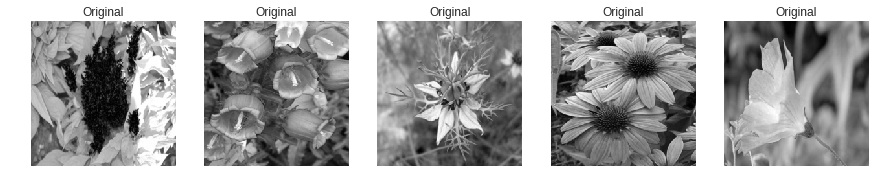

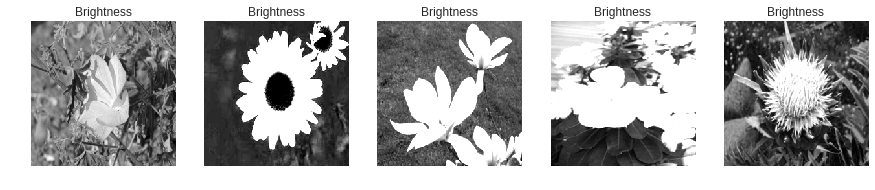

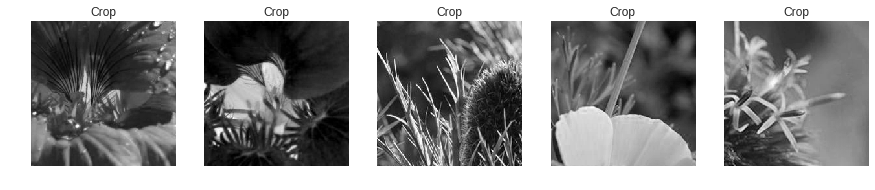

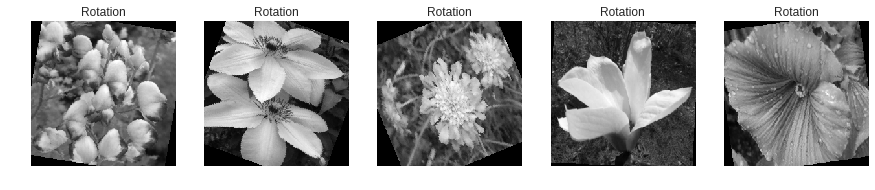

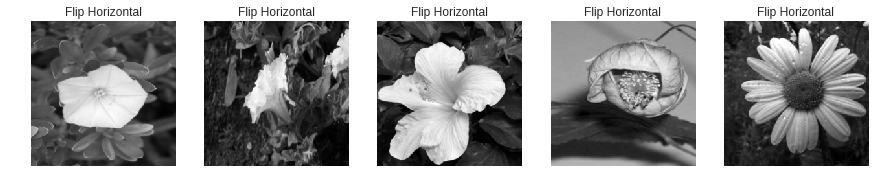

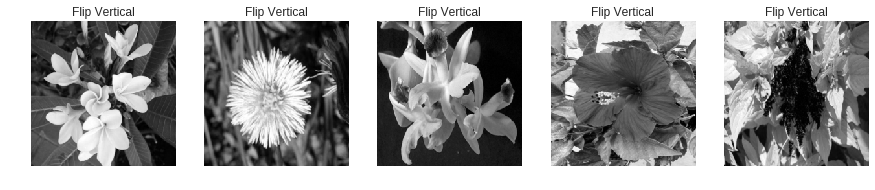

In [9]:
# Plot train
%matplotlib inline

for dataset in train_dataset:
    # Get batch
    images_train, labels_train = iter(dataset['data']).next()
    
    # Create buffer
    figure, axe = pp.subplots(nrows = 1, ncols = 5, figsize=(15, 10))
     
    # Plot images
    plot(axe = axe, images = images_train[:, 1], title = dataset['title'])

In [10]:
# Validation
height_validation, width_validation = 224, 224

batch_size_validation = 64

num_workers_validation = 0

# Transform
transform_validation = [
    torchvision.transforms.Resize((height_validation, width_validation)),
    torchvision.transforms.ToTensor(),
    normalize
]

# Validation
validation = torch.utils.data.DataLoader(
    load(path = path_validation, transform = torchvision.transforms.Compose(transform_validation)),
    batch_size = batch_size_validation,
    num_workers = num_workers_validation,
    shuffle = True
)

print(len(validation.dataset))

818


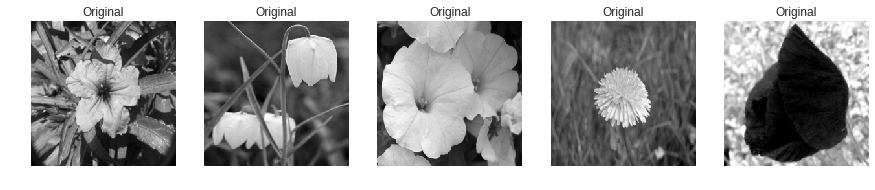

In [11]:
# Plot validation
%matplotlib inline

# Get batch
images_validation, labels_validation = iter(validation).next()

# Create buffer
figure, axe = pp.subplots(nrows = 1, ncols = 5, figsize=(15, 10))

# Plot images
plot(axe = axe, images = images_validation[:, 1], title = 'Original')

In [0]:
# Test dataset
# validation_size = int(0.8 * len(validation.dataset))

# test_size = int(len(validation.dataset) - validation_size)

# validation, test = torch.utils.data.random_split(validation.dataset, [validation_size, test_size])

# print(len(validation), len(test))

### Models

References:

1. [Rethinking the inception architecture for computer vision](https://arxiv.org/abs/1512.00567)

2. [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385)

3. [Unsupervised representation learning using convolutional and stacked auto-encoders: a domain and cross-domain feature space analysis](https://arxiv.org/abs/1811.00473)

#### Classes

In [13]:
classes = json.load(open(path_classes))

print(classes)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

#### Resnet 18

In [0]:
# Create a model
resnet18 = torchvision.models.resnet18(pretrained = True)

In [0]:
# Update dense layer
resnet18.fc = torch.nn.Linear(512, 102, bias = True)

In [0]:
# Freeze first layer
for parameter in resnet18.layer1.parameters():
    parameter.requires_grad = False

In [0]:
# Activate CUDA
if torch.cuda.is_available:
    resnet18 = resnet18.cuda()

In [0]:
# Define criterion
resnet18_criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
resnet18_optimizer = torch.optim.Adam(params = resnet18.parameters(), lr = 0.001)

# Define epochs
resnet18_epochs = 1

In [19]:
# Train
resnet18.train(mode = True)

resnet18_loss = []

for dataset in train_dataset:
    for epoch in range(resnet18_epochs):
        for batch, (images, labels) in enumerate(dataset['data']):
            # Activate CUDA
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            # Set the gradient to zero
            resnet18_optimizer.zero_grad()
            
            # Compute the output
            output = resnet18(images)
            
            # Compute the loss
            loss = resnet18_criterion(output, labels)
            
            resnet18_loss.append(loss)
            
            # Retro propagate
            loss.backward()

            resnet18_optimizer.step()
            
            # Print loss
            print('Epoch {0} | Batch {1} | Dataset {2}: {3} Loss'.format(epoch, batch, dataset['title'], loss))

Epoch 0 | Batch 0 | Dataset Original: 4.740992069244385 Loss
Epoch 0 | Batch 1 | Dataset Original: 4.441250324249268 Loss
Epoch 0 | Batch 2 | Dataset Original: 4.126208305358887 Loss
Epoch 0 | Batch 3 | Dataset Original: 3.822957754135132 Loss
Epoch 0 | Batch 4 | Dataset Original: 3.596463680267334 Loss
Epoch 0 | Batch 5 | Dataset Original: 3.4601805210113525 Loss
Epoch 0 | Batch 6 | Dataset Original: 3.267444372177124 Loss
Epoch 0 | Batch 7 | Dataset Original: 2.8695554733276367 Loss
Epoch 0 | Batch 8 | Dataset Original: 2.786561965942383 Loss
Epoch 0 | Batch 9 | Dataset Original: 2.6041147708892822 Loss
Epoch 0 | Batch 10 | Dataset Original: 2.9880738258361816 Loss
Epoch 0 | Batch 11 | Dataset Original: 2.4086644649505615 Loss
Epoch 0 | Batch 12 | Dataset Original: 2.7632532119750977 Loss
Epoch 0 | Batch 13 | Dataset Original: 2.2770798206329346 Loss
Epoch 0 | Batch 14 | Dataset Original: 2.6017956733703613 Loss
Epoch 0 | Batch 15 | Dataset Original: 2.025465965270996 Loss
Epoch 0 | 

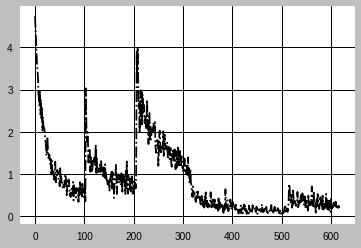

In [20]:
# Plot train loss
pp.style.use('grayscale')

pp.plot(resnet18_loss, linestyle = '-.')

In [0]:
# Accuracy
resnet18_class_correct = [0.] * len(classes)

resnet18_class_total = [0.] * len(classes)

# Disable gradient
with torch.no_grad():
    # Disable normalize and dropout
    resnet18.eval()
    
    for count, (images, labels) in enumerate(validation):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        
        # Compute the output
        output = resnet18(images)
        
        # Compute the loss
        # loss = resnet18_criterion_test(output, labels)
        
        # Get the max probabilities and its indices (classes)
        max_values, prediction = torch.max(output, 1)    
        
        # Compare predictions to true label
        correct = prediction.eq(labels.data.view_as(prediction))
        
        # Transform to 1D
        if torch.cuda.is_available():
            correct = np.squeeze(correct.cpu().numpy())
        else:
            correct = np.squeeze(correct.numpy())
        
        for c in range(len(images)):
            label = labels.data[c]
            
            resnet18_class_correct[label] += correct[c].item()
            
            resnet18_class_total[label] += 1

In [22]:
print('Model accuracy: {0}'.format(round(100. * np.sum(resnet18_class_correct) / np.sum(resnet18_class_total)), 2))

Model accuracy: 91.0
